# Tutorial: getting started with Delight

We will use the parameter file "tests/parametersTest.cfg".
This contains a description of the bands and data to be used.
In this example we will generate mock data for the ugriz SDSS bands,
fit each object with our GP using ugi bands only and see how it predicts the rz bands.
This is an example for filling in/predicting missing bands in a fully bayesian way
with a flexible SED model quickly via our photo-z GP.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys
sys.path.append('../')
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP

In [31]:
from delight.interfaces.rail.makeConfigParam import makeConfigParam

In [5]:
!pwd

/global/u1/d/dagoret/mydesc/Delight/notebooks


In [15]:
cd ../.

/global/u1/d/dagoret/mydesc/Delight


In [16]:
!pwd

/global/u1/d/dagoret/mydesc/Delight


In [9]:
#%cd Delight

In [55]:
input_param = {}
input_param["bands_names"]    = "lsst_u lsst_g lsst_r lsst_i lsst_z lsst_y"
input_param["bands_path"]     = "data/FILTERS"
input_param["bands_fmt"]      = "res"
input_param["bands_numcoefs"] = "15"
input_param["bands_verbose"]  = "True"
input_param["bands_debug"]    = "True"
input_param["bands_makeplots"]= "False"

input_param['sed_path']      = "data/SED" 
input_param['sed_name_list'] = "El_B2004a Sbc_B2004a Scd_B2004a SB3_B2004a SB2_B2004a Im_B2004a ssp_25Myr_z008 ssp_5Myr_z008"
input_param['sed_fmt']       = "sed"
input_param['prior_t_list']  = "0.27 0.26 0.25 0.069 0.021 0.11 0.0061 0.0079"
input_param['prior_zt_list'] = "0.23 0.39 0.33 0.31 1.1 0.34 1.2 0.14"
input_param['lambda_ref']    = "4.5e3"

input_param["tempdatadir"]   = "tmp"
input_param['train_refbandorder']  = "lsst_u lsst_u_var lsst_g lsst_g_var lsst_r lsst_r_var lsst_i lsst_i_var lsst_z lsst_z_var lsst_y lsst_y_var redshift"
input_param['train_refband']       = "lsst_i"
input_param['train_fracfluxerr']   = "1e-4"
input_param['train_xvalidate']     = "False"
input_param['train_xvalbandorder'] = "_ _ _ _ lsst_r lsst_r_var _ _ _ _ _ _"

input_param['target_refbandorder']  = "lsst_u lsst_u_var lsst_g lsst_g_var lsst_r lsst_r_var lsst_i lsst_i_var lsst_z lsst_z_var lsst_y lsst_y_var redshift"
input_param['target_refband']       = "lsst_r"
input_param['target_fracfluxerr']   = "1e-4"

input_param["zPriorSigma"]   = "0.2"
input_param["ellPriorSigma"] = "0.5"
input_param["fluxLuminosityNorm"] = "1.0"
input_param["alpha_C"]        = "1.0e3"
input_param["V_C"]            = "0.1"
input_param["alpha_L"]        = "1.0e2"
input_param["V_L"]            = "0.1"
input_param["lineWidthSigma"] = "20"

input_param["dlght_redshiftMin"]   = "0.1"
input_param["dlght_redshiftMax"]   = "1.101"
input_param["dlght_redshiftNumBinsGPpred"]  = "100"
input_param["dlght_redshiftBinSize"]        = "0.01"
input_param["dlght_redshiftDisBinSize"]     = "0.2"

In [57]:
paramfile_txt = makeConfigParam("data",input_param)

2022-01-21 14:07:20,923 __main__.py delight.interfaces.rail.makeConfigParam[31763] DEBUG __name__:delight.interfaces.rail.makeConfigParam
2022-01-21 14:07:20,925 __main__.py delight.interfaces.rail.makeConfigParam[31763] DEBUG __file__/global/homes/d/dagoret/mydesc/mydesc/lib/python3.8/site-packages/delight-1.0.1-py3.8-linux-x86_64.egg/delight/interfaces/rail/makeConfigParam.py
2022-01-21 14:07:20,925 __main__.py delight.interfaces.rail.makeConfigParam[31763] INFO ----- makeConfigParam ------
2022-01-21 14:07:20,926 __main__.py delight.interfaces.rail.makeConfigParam[31763] DEBUG  received path = data
2022-01-21 14:07:20,927 __main__.py delight.interfaces.rail.makeConfigParam[31763] DEBUG Decode redshift parameter from RAIL config file


In [58]:
print(paramfile_txt)


# DELIGHT parameter file
# Syntactic rules:
# - You can set parameters with : or =
# - Lines starting with # or ; will be ignored
# - Multiple values (band names, band orders, confidence levels)
#   must beb separated by spaces
# - The input files should contain numbers separated with spaces.
# - underscores mean unused column

[Bands]
names: lsst_u lsst_g lsst_r lsst_i lsst_z lsst_y
directory: data/FILTERS
bands_fmt: res
numCoefs: 15
bands_verbose: True
bands_debug: True
bands_makeplots: False

[Templates]
directory: data/SED
names: El_B2004a Sbc_B2004a Scd_B2004a SB3_B2004a SB2_B2004a Im_B2004a ssp_25Myr_z008 ssp_5Myr_z008
sed_fmt: sed
p_t: 0.27 0.26 0.25 0.069 0.021 0.11 0.0061 0.0079
p_z_t: 0.23 0.39 0.33 0.31 1.1 0.34 1.2 0.14
lambdaRef: 4.5e3

[Simulation]
numObjects: 1000
noiseLevel: 0.03
trainingFile: tmp/galaxies-fluxredshifts.txt
targetFile: tmp/galaxies-fluxredshifts2.txt

[Training]
catFile: tmp/galaxies-fluxredshifts.txt
bandOrder: lsst_u lsst_u_var lsst_g lsst_g_var lsst

In [59]:
with open('tests/parametersTestRail.cfg','w') as out:
    out.write(paramfile_txt)

## Creating the parameter file
Let's create a parameter file from scratch.

In [17]:
paramfile_txt = """
# DELIGHT parameter file
# Syntactic rules:
# - You can set parameters with : or =
# - Lines starting with # or ; will be ignored
# - Multiple values (band names, band orders, confidence levels)
#   must beb separated by spaces
# - The input files should contain numbers separated with spaces.
# - underscores mean unused column
"""

Let's describe the bands we will use. This must be a superset (ideally the union) of all the bands involved in the training and target sets, including cross-validation. 

Each band should have its own file, containing a tabulated version of the filter response.

See example files shipped with the code for formatting.

In [18]:
paramfile_txt += """
[Bands]
names: U_SDSS G_SDSS R_SDSS I_SDSS Z_SDSS
directory: data/FILTERS
"""

Let's now describe the system of SED templates to use (needed for the mean fct of the GP, for simulating objects, and for the template fitting routines).

Each template should have its own file (see shipped files for formatting example). 

lambdaRef will be the pivot wavelenght used for normalizing the templates.

p_z_t and p_t containts parameters for the priors of each template, for p(z|t) p(t). 

Calibrating those numbers will be the topic of another tutorial.

By default the set of templates and the prior calibration can be left untouched.

In [19]:
paramfile_txt += """
[Templates]
directory: ./data/CWW_SEDs
names: El_B2004a Sbc_B2004a Scd_B2004a SB3_B2004a SB2_B2004a Im_B2004a ssp_25Myr_z008 ssp_5Myr_z008
p_t: 0.27 0.26 0.25 0.069 0.021 0.11 0.0061 0.0079
p_z_t:0.23 0.39 0.33 0.31 1.1 0.34 1.2 0.14
lambdaRef: 4.5e3
"""

The next section if for simulating a photometric catalogue from the templates. 

catalog files (trainingFile, targetFile) will be created, and have the adequate format for the later stages. 

noiseLevel describes the relative error for the absolute flux in each band.

In [20]:
paramfile_txt += """
[Simulation]
numObjects: 1000
noiseLevel: 0.03
trainingFile: data/galaxies-fluxredshifts.txt
targetFile: data/galaxies-fluxredshifts2.txt
"""

We now describe the training file.

`catFile` is the input catalog. This should be a tab or space separated file with numBands + 1 columns.

`bandOrder` describes the ordering of the bands in the file. Underscore `_` means an ignored column, for example a band that shouldn't be used. The band names must correspond to those in the filter section.

`redshift` is for the photometric redshift. `referenceBand` is the reference band for normalizing the fluxes and luminosities. `extraFracFluxError` is an extra relative error to add in quadrature to the flux errors.

`paramFile` will contain the output of the GP applied to the training galaxies, i.e. the minimal parameters that must be stored in order to reconstruct the fit of each GP.

`crossValidate` is a flag for performing optional cross-validation. If so, `CVfile` will contain cross-validation data. `crossValidationBandOrder` is similar to `bandOrder` and describes the bands to be used for cross-validation. In this example I have left the R band out of `bandOrder` and put it in `crossValidationBandOrder`. However, this feature won't work on simulated data, only on real data (i.e., the `simulateWithSEDs` script below does not generate cross-validation bands).

`numChunks` is the number of chunks to split the training data into. At present please stick to 1.

In [21]:
paramfile_txt += """
[Training]
catFile: data/galaxies-fluxredshifts.txt
bandOrder: U_SDSS U_SDSS_var G_SDSS G_SDSS_var _ _ I_SDSS I_SDSS_var Z_SDSS Z_SDSS_var redshift
referenceBand: I_SDSS
extraFracFluxError: 1e-4
paramFile: data/galaxies-gpparams.txt
crossValidate: False
CVfile: data/galaxies-gpCV.txt
crossValidationBandOrder: _ _ _ _ R_SDSS R_SDSS_var _ _ _ _ _
numChunks: 1
"""

The section of the target catalog has very similar structure and parameters. The `catFile`, `bandOrder`, `referenceBand`, and `extraFracFluxError` have the same meaning as for the training, but of course don't have to be the same.

`redshiftpdfFile` and `redshiftpdfFileTemp` will contain tabulated redshift posterior PDFs for the delight-apply and templateFitting scripts. 

Similarly, `metricsFile` and `metricsFileTemp` will contain metrics calculated from the PDFs, like mean, mode, etc. This is particularly informative if `redshift` is also provided in the target set.

The compression mode can be activated with `useCompression` and will produce new redshift PDFs in the file `redshiftpdfFileComp`, while `compressIndicesFile` and `compressMargLikFile` will contain the indices and marginalized likelihood for the objects that were kept during compression. The number of objects is controled with `Ncompress`.

In [22]:
paramfile_txt += """
[Target]
catFile: data/galaxies-fluxredshifts2.txt
bandOrder: U_SDSS U_SDSS_var G_SDSS G_SDSS_var _ _ I_SDSS I_SDSS_var Z_SDSS Z_SDSS_var redshift
referenceBand: I_SDSS
extraFracFluxError: 1e-4
redshiftpdfFile: data/galaxies-redshiftpdfs.txt
redshiftpdfFileTemp: data/galaxies-redshiftpdfs-cww.txt
metricsFile:  data/galaxies-redshiftmetrics.txt
metricsFileTemp:  data/galaxies-redshiftmetrics-cww.txt
useCompression: False
Ncompress: 10
compressIndicesFile: data/galaxies-compressionIndices.txt
compressMargLikFile: data/galaxies-compressionMargLikes.txt
redshiftpdfFileComp: data/galaxies-redshiftpdfs-comp.txt
"""

Finally, there are various other parameters related to the method itself.

The (hyper)parameters of the Gaussian process are `zPriorSigma`, `ellPriorSigma` (locality of the model predictions in redshift and luminosity), `fluxLuminosityNorm` (some normalization parameter), `alpha_C`, `alpha_L`, `V_C`, `V_L` (smoothness and variance of the latent SED model), `lines_pos`, `lines_width` (positions and widths of the lines in the latent SED model). 

`redshiftMin`, `redshiftMax`, and `redshiftBinSize` describe the linear fine redshift grid to compute PDFs on.

`redshiftNumBinsGPpred` describes the granuality (in log scale!) for the GP kernel to be exactly calculated on; it will then be interpolated on the finer grid.

`redshiftDisBinSize` is the binsize for a tomographic redshift binning.

`confidenceLevels` are the confidence levels to compute in the redshift PDF metrics.

The values below should be a good default set for all of those parameters. 

In [23]:
paramfile_txt += """
[Other]
rootDir: ./
zPriorSigma: 0.2
ellPriorSigma: 0.5
fluxLuminosityNorm: 1.0
alpha_C: 1.0e3
V_C: 0.1
alpha_L: 1.0e2
V_L: 0.1
lines_pos: 6500 5002.26 3732.22
lines_width: 20.0 20.0 20.0
redshiftMin: 0.1
redshiftMax: 1.101
redshiftNumBinsGPpred: 100
redshiftBinSize: 0.001
redshiftDisBinSize: 0.2
confidenceLevels: 0.1 0.50 0.68 0.95
"""

Let's write this to a file.

In [24]:
with open('tests/parametersTest.cfg','w') as out:
    out.write(paramfile_txt)

## Running Delight

### Processing the filters and templates, and create a mock catalog

First, we must fit the band filters with a gaussian mixture. 
This is done with this script:

In [26]:
#%run ./scripts/processFilters.py tests/parametersTest.cfg
processFilters("tests/parametersTest.cfg")

TypeError: 'module' object is not callable

Second, we will process the library of SEDs and project them onto the filters,
(for the mean fct of the GP) with the following script (which may take a few minutes depending on the settings you set):

In [29]:
%run ./scripts/processSEDs.py tests/parametersTest.cfg

Third, we will make some mock data with those filters and SEDs:

In [30]:
%run ./scripts/simulateWithSEDs.py tests/parametersTest.cfg

### Train and apply
Run the scripts below. There should be a little bit of feedback as it is going through the lines.
For up to 1e4 objects it should only take a few minutes max, depending on the settings above.

In [31]:
%run ./scripts/templateFitting.py tests/parametersTest.cfg

--- TEMPLATE FITTING ---
Thread number / number of threads:  1 1
Input parameter file: tests/parametersTest.cfg
Number of Target Objects 1000
Thread  0  analyzes lines  0  to  1000


/global/u1/d/dagoret/mydesc/Delight/scripts/templateFitting.py:45: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTarget = np.sum(1 for line in open(params['target_catFile']))


localPDFs.shape =  (1000, 1001)
globalPDFs.shape =  (1000, 1001)
localMetrics.shape =  (1000, 11)
globalMetrics.shape =  (1000, 11)


In [32]:
%run ./scripts/delight-learn.py tests/parametersTest.cfg

--- DELIGHT-LEARN ---
Number of Training Objects 1000
Thread  0  analyzes lines  0  to  1000


/global/u1/d/dagoret/mydesc/Delight/scripts/delight-learn.py:29: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))


In [33]:
%run ./scripts/delight-apply.py tests/parametersTest.cfg

--- DELIGHT-APPLY ---
Number of Training Objects 1000
Number of Target Objects 1000
Thread  0  analyzes lines  0  to  1000


/global/u1/d/dagoret/mydesc/Delight/scripts/delight-apply.py:45: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))
/global/u1/d/dagoret/mydesc/Delight/scripts/delight-apply.py:46: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTarget = np.sum(1 for line in open(params['target_catFile']))


0 0.18335247039794922 0.012462615966796875 0.009143352508544922
100 0.19920706748962402 0.012188196182250977 0.008258581161499023
200 0.17625975608825684 0.014019489288330078 0.008650779724121094
300 0.1740427017211914 0.012225866317749023 0.00742650032043457
400 0.19935202598571777 0.012373685836791992 0.008277654647827148
500 0.1647047996520996 0.012132883071899414 0.008857250213623047
600 0.17248272895812988 0.014067649841308594 0.009053468704223633
700 0.1640918254852295 0.010851144790649414 0.008731842041015625
800 0.17292046546936035 0.012299776077270508 0.008840322494506836
900 0.18146729469299316 0.015091657638549805 0.008534669876098633


## Analyze the outputs

In [34]:
# First read a bunch of useful stuff from the parameter file.
params = parseParamFile('tests/parametersTest.cfg', verbose=False)
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms\
    = readBandCoefficients(params)
bandNames = params['bandNames']
numBands, numCoefs = bandCoefAmplitudes.shape
fluxredshifts = np.loadtxt(params['target_catFile'])
fluxredshifts_train = np.loadtxt(params['training_catFile'])
bandIndices, bandNames, bandColumns, bandVarColumns, redshiftColumn,\
            refBandColumn = readColumnPositions(params, prefix='target_')
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
dir_seds = params['templates_directory']
dir_filters = params['bands_directory']
lambdaRef = params['lambdaRef']
sed_names = params['templates_names']
nt = len(sed_names)
f_mod = np.zeros((redshiftGrid.size, nt, len(params['bandNames'])))
for t, sed_name in enumerate(sed_names):
    f_mod[:, t, :] = np.loadtxt(dir_seds + '/' + sed_name + '_fluxredshiftmod.txt')

In [35]:
# Load the PDF files
metricscww = np.loadtxt(params['metricsFile'])
metrics = np.loadtxt(params['metricsFileTemp'])
# Those of the indices of the true, mean, stdev, map, and map_std redshifts.
i_zt, i_zm, i_std_zm, i_zmap, i_std_zmap = 0, 1, 2, 3, 4
i_ze = i_zm
i_std_ze = i_std_zm

pdfs = np.loadtxt(params['redshiftpdfFile'])
pdfs_cww = np.loadtxt(params['redshiftpdfFileTemp'])
pdfatZ_cww = metricscww[:, 5] / pdfs_cww.max(axis=1)
pdfatZ = metrics[:, 5] / pdfs.max(axis=1)
nobj = pdfatZ.size
#pdfs /= pdfs.max(axis=1)[:, None]
#pdfs_cww /= pdfs_cww.max(axis=1)[:, None]
pdfs /= np.trapz(pdfs, x=redshiftGrid, axis=1)[:, None]
pdfs_cww /= np.trapz(pdfs_cww, x=redshiftGrid, axis=1)[:, None]

686 822 261 274 804 110 353 870 106 313 99 679 920 319 718 530 246 972 623 187 

/tmp/ipykernel_50038/1794643373.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


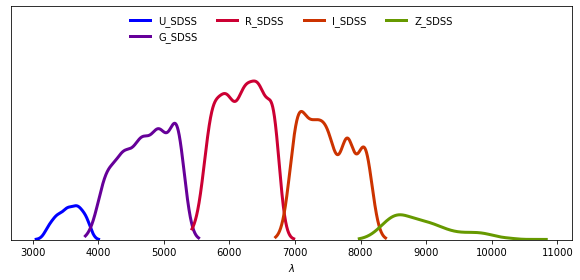

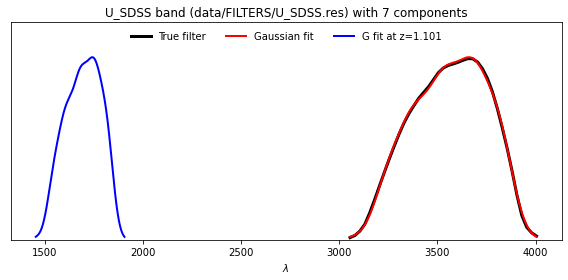

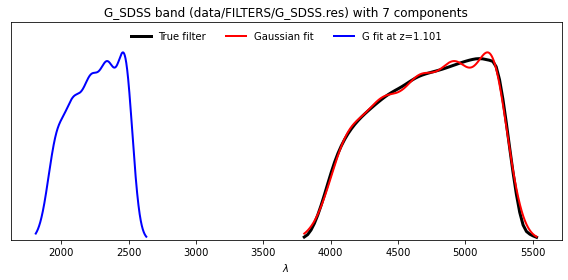

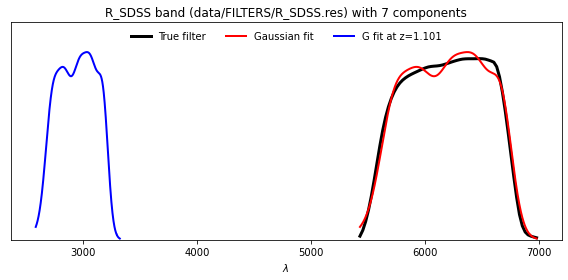

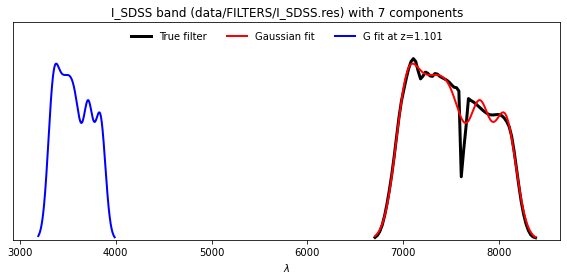

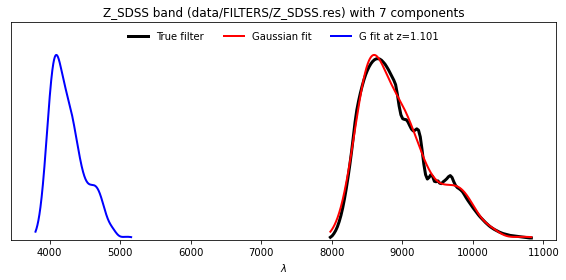

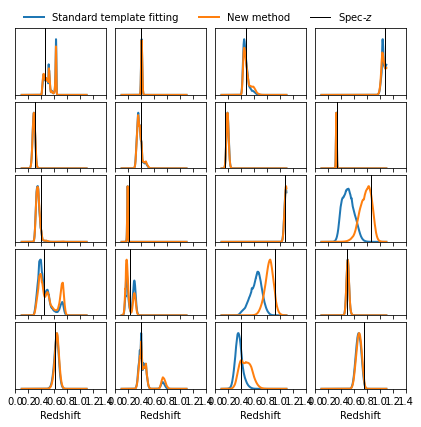

In [36]:
ncol = 4
fig, axs = plt.subplots(5, ncol, figsize=(7, 6), sharex=True, sharey=False)
axs = axs.ravel()
z = fluxredshifts[:, redshiftColumn]
sel = np.random.choice(nobj, axs.size, replace=False)
lw = 2
for ik in range(axs.size):
    k = sel[ik]
    print(k, end=" ")
    axs[ik].plot(redshiftGrid, pdfs_cww[k, :],lw=lw, label='Standard template fitting')# c="#2ecc71", 
    axs[ik].plot(redshiftGrid, pdfs[k, :], lw=lw, label='New method')  #, c="#3498db"
    axs[ik].axvline(fluxredshifts[k, redshiftColumn], c="k", lw=1, label=r'Spec-$z$')
    ymax = np.max(np.concatenate((pdfs[k, :], pdfs_cww[k, :])))
    axs[ik].set_ylim([0, ymax*1.2])
    axs[ik].set_xlim([0, 1.1])
    axs[ik].set_yticks([])
    axs[ik].set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
for i in range(ncol):
    axs[-i-1].set_xlabel('Redshift', fontsize=10)
axs[0].legend(ncol=3, frameon=False, loc='upper left', bbox_to_anchor=(0.0, 1.4))
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.96)


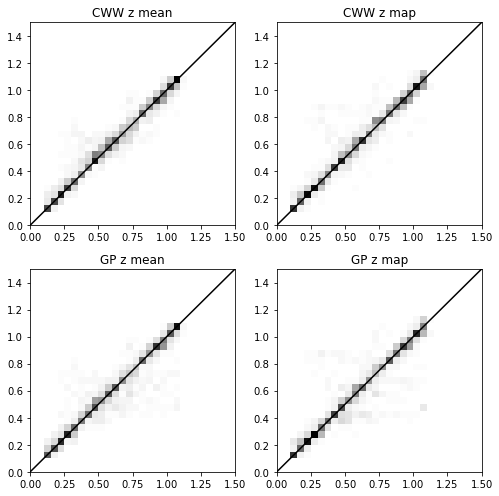

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
zmax = 1.5
rr = [[0, zmax], [0, zmax]]
nbins = 30
h = axs[0, 0].hist2d(metricscww[:, i_zt], metricscww[:, i_zm], nbins, cmap='Greys', range=rr)
hmin, hmax = np.min(h[0]), np.max(h[0])
axs[0, 0].set_title('CWW z mean')
axs[0, 1].hist2d(metricscww[:, i_zt], metricscww[:, i_zmap], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[0, 1].set_title('CWW z map')
axs[1, 0].hist2d(metrics[:, i_zt], metrics[:, i_zm], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[1, 0].set_title('GP z mean')
axs[1, 1].hist2d(metrics[:, i_zt], metrics[:, i_zmap], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[1, 1].set_title('GP z map')
axs[0, 0].plot([0, zmax], [0, zmax], c='k')
axs[0, 1].plot([0, zmax], [0, zmax], c='k')
axs[1, 0].plot([0, zmax], [0, zmax], c='k')
axs[1, 1].plot([0, zmax], [0, zmax], c='k')
fig.tight_layout()

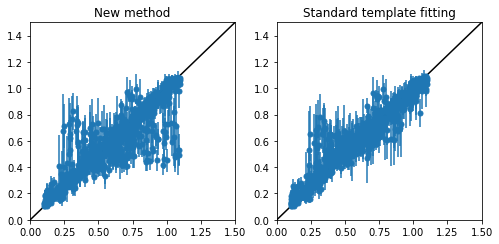

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))
chi2s = ((metrics[:, i_zt] - metrics[:, i_ze])/metrics[:, i_std_ze])**2

axs[0].errorbar(metrics[:, i_zt], metrics[:, i_ze], yerr=metrics[:, i_std_ze], fmt='o', markersize=5, capsize=0)
axs[1].errorbar(metricscww[:, i_zt], metricscww[:, i_ze], yerr=metricscww[:, i_std_ze], fmt='o', markersize=5, capsize=0)
axs[0].plot([0, zmax], [0, zmax], 'k')
axs[1].plot([0, zmax], [0, zmax], 'k')
axs[0].set_xlim([0, zmax])
axs[1].set_xlim([0, zmax])
axs[0].set_ylim([0, zmax])
axs[1].set_ylim([0, zmax])
axs[0].set_title('New method')
axs[1].set_title('Standard template fitting')

fig.tight_layout()

Text(0.5, 1.0, 'New method')

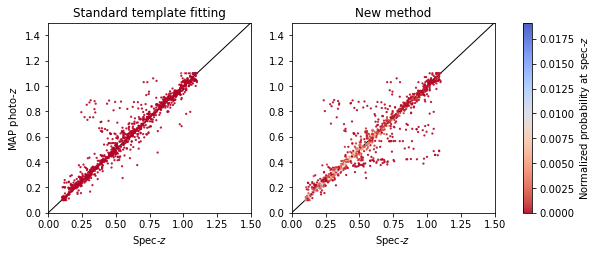

In [39]:
cmap = "coolwarm_r"
vmin = 0.0
alpha = 0.9
s = 5
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))
vs = axs[0].scatter(metricscww[:, i_zt], metricscww[:, i_zmap], 
                    s=s, c=pdfatZ_cww, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
vs = axs[1].scatter(metrics[:, i_zt], metrics[:, i_zmap], 
                    s=s, c=pdfatZ, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
clb = plt.colorbar(vs, ax=axs.ravel().tolist())
clb.set_label('Normalized probability at spec-$z$')
for i in range(2):
    axs[i].plot([0, zmax], [0, zmax], c='k', lw=1, zorder=0, alpha=1)
    axs[i].set_ylim([0, zmax])
    axs[i].set_xlim([0, zmax])
    axs[i].set_xlabel('Spec-$z$')
axs[0].set_ylabel('MAP photo-$z$')

axs[0].set_title('Standard template fitting')
axs[1].set_title('New method')

## Conclusion
Don't be too harsh with the results of the standard template fitting or the new methods since both have a lot of parameters which can be optimized!

If the results above made sense, i.e. the redshifts are reasonnable for both methods on the mock data, then you can start modifying the parameter files and creating catalog files containing actual data! I recommend using less than 20k galaxies for training, and 1000 or 10k galaxies for the delight-apply script at the moment. Future updates will address this issue.